In [28]:
%matplotlib inline
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [29]:
dane = "/DATA/shared/datasets/cifar10/cifar10_test.tfrecord"
dane_train = "/DATA/shared/datasets/cifar10/cifar10_train.tfrecord"

## Input pipeline
https://www.tensorflow.org/api_guides/python/io_ops#Input_pipeline

### net

In [15]:
def read_data(filename_queue):
    reader = tf.TFRecordReader()
    _, se = reader.read(filename_queue)
    f = tf.parse_single_example(se,features={'image/encoded':tf.FixedLenFeature([],tf.string),
                                            'image/class/label':tf.FixedLenFeature([],tf.int64),
                                            'image/height':tf.FixedLenFeature([],tf.int64),
                                            'image/width':tf.FixedLenFeature([],tf.int64)})
    image = tf.image.decode_png(f['image/encoded'],channels=3)
    image.set_shape( (32,32,3) ) 
    return image,f['image/class/label']

In [16]:
#with tf.device('/cpu:0'):
fq = tf.train.string_input_producer([dane_train])
image_data, label = read_data(filename_queue=fq)

In [17]:
batch_size = 128
images, sparse_labels = tf.train.shuffle_batch( [image_data,label],batch_size=batch_size,
                                               num_threads=2,
                                               capacity=1000+3*batch_size,
                                               min_after_dequeue=1000
                                               )
images = (tf.cast(images,tf.float32)-128.0)/33.0

In [18]:
## test queue 
fq_test = tf.train.string_input_producer([dane])
test_image_data, test_label = read_data(filename_queue=fq_test)
batch_size = 4100
test_images, test_sparse_labels = tf.train.batch( [test_image_data,test_label],batch_size=batch_size,
                                               num_threads=2,
                                               capacity=1000+3*batch_size,
                                               )
test_images = (tf.cast(test_images,tf.float32)-128.0)/33.0

In [19]:
am_testing = tf.placeholder(dtype=bool,shape=())
images = tf.cond(am_testing, lambda:test_images, lambda:images)
sparse_labels = tf.cond(am_testing, lambda:test_sparse_labels, lambda:sparse_labels)

In [20]:
net = tf.contrib.layers.conv2d( images, 32, 3, padding='VALID')
net = tf.contrib.layers.max_pool2d( net, 2, 2, padding='VALID')

net = tf.contrib.layers.conv2d( net, 32, 3, padding='VALID')
net = tf.contrib.layers.max_pool2d( net, 2, 2, padding='VALID')

net = tf.contrib.layers.conv2d( net, 32, 3, padding='VALID')
net = tf.contrib.layers.max_pool2d( net, 2, 2, padding='VALID')

net = tf.contrib.layers.fully_connected(tf.reshape(net,[-1,2*2*32]), 32)
net = tf.contrib.layers.fully_connected(net, 10, activation_fn=None)
logits = net

xent = tf.losses.sparse_softmax_cross_entropy(sparse_labels,net)
loss = tf.reduce_mean( xent)

opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = opt.minimize(loss)

In [21]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.50

sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess,coord=coord)

In [22]:
from IPython.display import clear_output

In [11]:
lvals = []

#f,ax = plt.subplot()
for i in range(5098):
    l, _ = sess.run([loss,train_op],feed_dict={am_testing: False})
    clear_output(wait=True)
    print(l,i+1)

2.27839 9


KeyboardInterrupt: 

In [26]:
sess.run(test_sparse_labels).shape

(100,)

In [14]:
sess.run(test_labels).shape

(100,)

In [28]:
sess.run(images,feed_dict={am_testing: True}).shape

(100, 32, 32, 3)

In [29]:
sess.run(test_sparse_labels)

array([9, 8, 7, 8, 8, 4, 0, 1, 8, 2, 7, 9, 3, 6, 1, 9, 0, 7, 3, 7, 4, 5, 0,
       0, 2, 9, 3, 4, 0, 6, 2, 5, 3, 7, 3, 7, 2, 5, 3, 1, 1, 4, 9, 9, 5, 7,
       5, 0, 2, 2, 2, 9, 7, 3, 9, 4, 3, 5, 4, 6, 5, 6, 1, 4, 3, 4, 4, 3, 7,
       8, 3, 7, 8, 0, 5, 7, 6, 0, 5, 4, 8, 6, 8, 5, 5, 9, 9, 9, 5, 0, 1, 0,
       8, 1, 1, 8, 0, 2, 2, 0])

In [26]:
label2txt = ["airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck" ]


In [23]:

predicted = np.argmax(sess.run(logits,feed_dict={am_testing: True}),axis=1)
local_images = sess.run(images,feed_dict={am_testing: True})
true_labels = sess.run(sparse_labels,feed_dict={am_testing: True})

In [24]:
predicted.shape

(4100,)

cat airplane


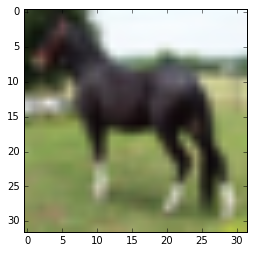

cat airplane


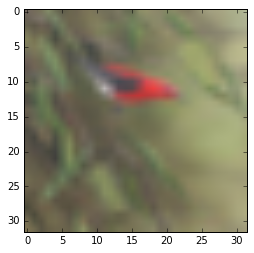

dog truck


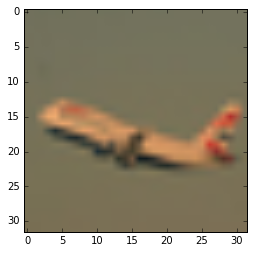

cat truck


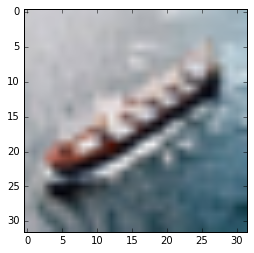

cat airplane


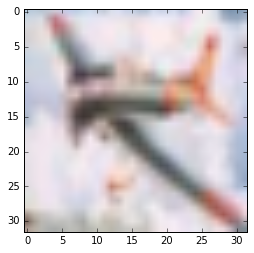

bird truck


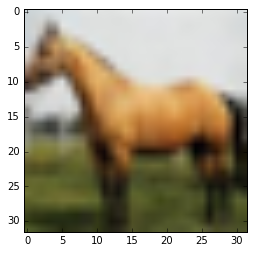

horse horse


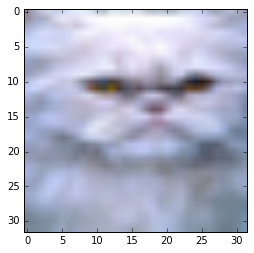

horse truck


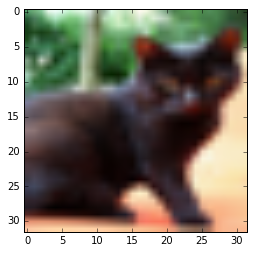

ship truck


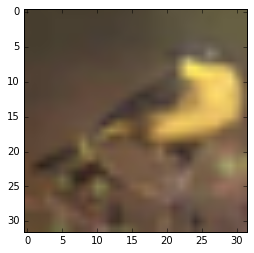

bird truck


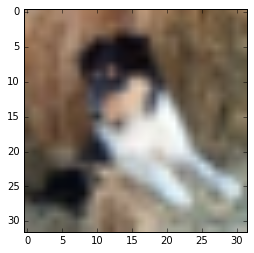

airplane airplane


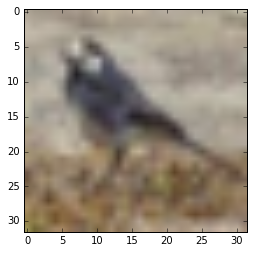

dog airplane


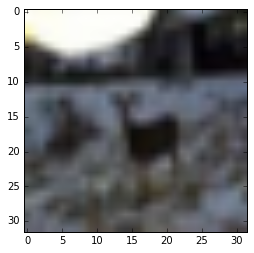

dog truck


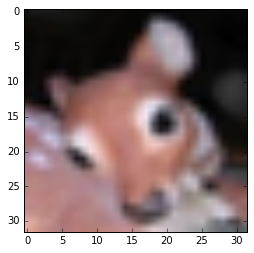

frog airplane


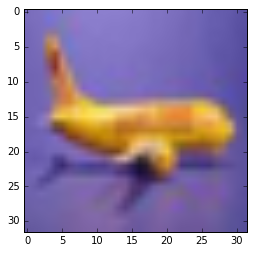

automobile truck


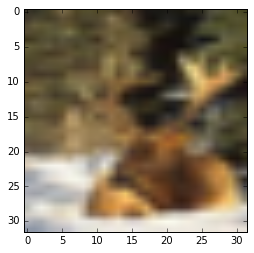

automobile airplane


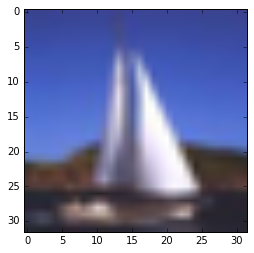

cat airplane


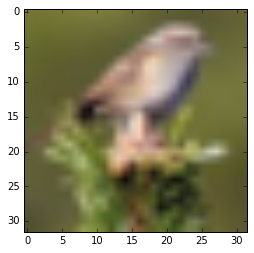

truck truck


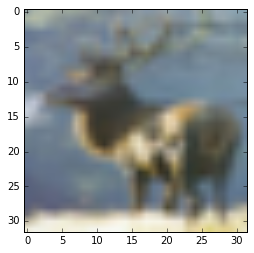

truck airplane


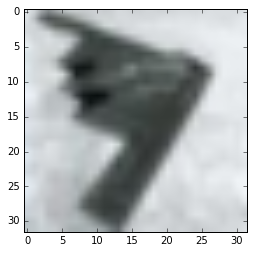

cat airplane


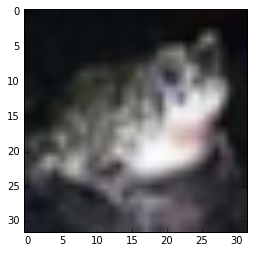

In [27]:
for ith in range(20):
    print (label2txt[true_labels[ith]],(label2txt[predicted[ith]]))
    plt.imshow((local_images[ith]*33+128).astype(np.uint8))
    plt.show()

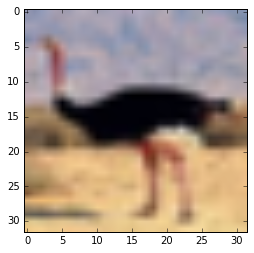

In [95]:
plt.imshow(sess.run(image_data))